# Исследование данных о пользователях и совершенных ими поездках на самокатах сервиса аренды самокатов GoFast.

В нашем распоряжении данные о некоторых пользователях из нескольких городов, а также об их поездках: 
- файл `users_go.csv` содержит информацию о пользователях: уникальный идентификатор пользователя (user_id), имя пользователя (name), возраст (age), город (city), тип подписки - free или ultra (subscription_type);
- файл `rides_go.csv` содержит информацию о пользователях: уникальный идентификатор пользователя (user_id), расстояние, которое пользователь проехал в текущей сессии в метрах (distance), продолжительность сессии в минутах — время с того момента, как пользователь нажал кнопку «Начать поездку» до момента, как он нажал кнопку «Завершить поездку» (duration), дата совершения поездки (date);
- файл `subscriptions_go.csv` содержит информацию о тарифах аренды: тип подписки (subscription_type), стоимость одной минуты поездки по данной подписке (minute_price), стоимость начала поездки (start_ride_price), стоимость ежемесячного платежа (subscription_fee).

Чтобы совершать поездки по городу, пользователи сервиса GoFast пользуются мобильным приложением. Сервисом можно пользоваться:
- без подписки:
    - абонентская плата отсутствует;
    - стоимость одной минуты поездки — 8 рублей;
    - стоимость старта (начала поездки) — 50 рублей;
- с подпиской Ultra:
    - абонентская плата — 199 рублей в месяц;
    - стоимость одной минуты поездки — 6 рублей;
    - стоимость старта — бесплатно.

**Цель исследования** - проверить следующие ***гипотезы***, которые могут помочь бизнесу вырасти в результате проведения акций, способствующих увеличению количества пользователей с подпиской:
1. Пользователи с подпиской тратят больше времени на поездки. Если гипотеза не опровергнется, то пользователи с подпиской могут быть «выгоднее» для компании. Для проверки гипотезы используем исходные данные о продолжительности каждой сессии — отдельно для подписчиков и тех, у кого нет подписки.
2. Среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает оптимального расстояния с точки зрения износа самоката (3130 метров). Проверим гипотезу, используя исходные данные о расстоянии каждой сессии пользователей с подпиской. Если гипотеза не опровергнется, то пользователи с подпиской могут быть причиной быстрого износа парка самокатов, что увеличивает расходы компании, тем самым снижая прибыль.
3. Помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки. Проверим гипотезу, используя исходные данные о количестве и длительности поездок пользователей и тарифах аренды. Если гипотеза не опровергнется, то пользователи с подпиской могут быть «выгоднее» для компании.

*Иследование проведем по следующим этапам*:
1. Изучим содержание данных, выявим наличие данных, требующих их предобработки (неудобный тип данных, дубликаты и пропуски).
2. Проведем предобработку данных:
    - приведем к удобному формату данных;    
    - удалим дубликаты при наличии;
    - заполним пропуски значений, где это возможно;
    - добавим при необходимости дополнительные столбцы с данными.
3. Проведем исследовательский анализ данных о пользователях и поездках:
    - частота встречаемости городов, в которых совершены поездки;
    - соотношение пользователей с подпиской и без подписки;
    - возраст пользователей;
    - расстояние, которое пользователь преодолел за одну поездку;
    - продолжительность поездок, совершенных пользователями;
    - расстояние и продолжительность поездок для пользователей разных категорий: с подпиской и без нее;
    - рассчитаем объем помесячной выручки от пользователей.
4. Проверим сформулированные выше гипотезы.
5. Оформим полученные результаты.

In [1]:
# импортируем необходимые библиотеки:
import pandas as pd
import numpy as np
from scipy import stats as st
import matplotlib.pyplot as plt
from scipy.stats import binom, norm

#### Шаг 1. Загрузка данных

1. Изучим файл с информацией о пользователях.

In [2]:
users = pd.read_csv ('/datasets/users_go.csv')
users.head()

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


In [3]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


Файл содержит информацию о 1565 пользователях, в том числе их уникальный номер, имя, возраст, город и тип выбранного тарифа.

2. Изучим файл с информацией о поездках пользователей.

In [4]:
rides = pd.read_csv ('/datasets/rides_go.csv')
rides.head()

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


In [5]:
rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


In [6]:
rides ['date'].max()

'2021-12-30'

In [7]:
rides ['date'].min()

'2021-01-01'

Файл содержит информацию о 18068 поездках, совершенных пользователями в период с 1 января по 30 декабря 2021 года, в том числе уникальный номер пользователя, расстояние поездки, длительность поездки и дата поездки.

3. Изучим файл с информацией о тарифах аренды.

In [8]:
prices = pd.read_csv ('/datasets/subscriptions_go.csv')
prices

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


In [9]:
prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


Всего представлены 2 тарифа - с подпиской Ultra и без нее, включающме в себя стоимость минуты поездки, стоимость старта (для тарифа без подписки) и стоимость абонентской платы в месяц (для тарифа с подпиской Ultra).

#### Шаг 2. Предобработка данных

Cтолбец `date` в файле с информацией о поездках имеет текстовый тип данных "object", при этом в нем отражена дата поездки. Для удобства последующей обработки данных изменим формат типа данных в этом столбце на тип даты "date":

In [10]:
rides ['date'] = pd.to_datetime(rides ['date'], format='%Y-%m-%d')

Для последующего расчета общей стоимости поездок, совершенных пользователем за месяц, добавим в файл с информацией о поездках столбец, содержащий сведения о месяце совершения поездки:

In [11]:
rides ['month'] = pd.DatetimeIndex (rides ['date']).month
rides.head()

,user_id,distance,duration,date,month
0,1,4409.919140,25.599769,2021-01-01,1
1,1,2617.592153,15.816871,2021-01-18,1
2,1,754.159807,6.232113,2021-04-20,4
3,1,2694.783254,18.511000,2021-08-11,8
4,1,4028.687306,26.265803,2021-08-28,8


Пропущенные значения в файлах отсутствуют. Проверим на наличие дубликатов и в случае обнаружения удалим их.

In [12]:
users.duplicated().sum()

31

In [13]:
rides.duplicated().sum()

0

In [14]:
users = users.drop_duplicates().reset_index(drop=True)
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1534 entries, 0 to 1533
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1534 non-null   int64 
 1   name               1534 non-null   object
 2   age                1534 non-null   int64 
 3   city               1534 non-null   object
 4   subscription_type  1534 non-null   object
dtypes: int64(2), object(3)
memory usage: 60.0+ KB


После удаления 31 повторяющейся строки в файле с информацией о пользователях, осталось 1534 уникальных пользователя.

#### Шаг 3. Исследовательский анализ данных

1. Посмотрим в каких *городах* пользователи чаще пользуются услугой аренды самокатов GoFast.

In [15]:
cities = users['city'].value_counts(ascending=True)
cities

Москва            168
Тюмень            180
Омск              183
Сочи              189
Краснодар         193
Ростов-на-Дону    198
Екатеринбург      204
Пятигорск         219
Name: city, dtype: int64

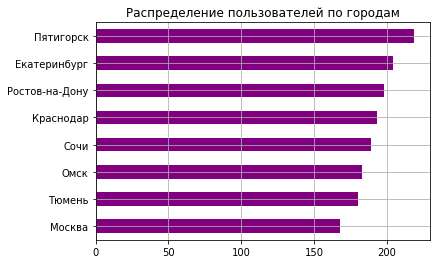

In [16]:
cities.plot(kind='barh', x='city', title='Распределение пользователей по городам', grid=True, color='purple');

Услугой аренды самокатов GoFast пользуются в 8 городах примерно одинаково, но наибольшее распространение услуга имеет в г. Пятигорске (219 пользователей), меньше всего представлены пользователи из г. Москвы (168 пользователей).

2. Посмотрим на соотношение пользователей с *подпиской* Ultra и без нее.

In [17]:
users['subscription_type'].value_counts()

free     835
ultra    699
Name: subscription_type, dtype: int64

<AxesSubplot:title={'center':'Распределение пользователей в зависимости от наличия подписки'}, ylabel='subscription_type'>

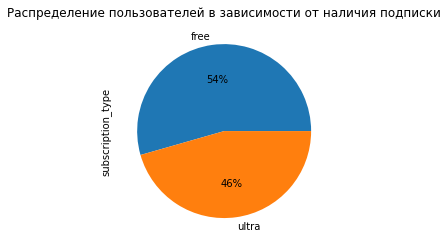

In [18]:
(
    users['subscription_type']
    .value_counts()
    .plot(kind='pie', autopct='%1.0f%%', title='Распределение пользователей в зависимости от наличия подписки')
)

Пользователей без подписки на 8% больше, чем пользователей, оформивших подписку Ultra.

3. Посмотрим на распределение пользователей услуги аренды самокатов GoFast в зависимости от их *возраста*.

In [19]:
users['age'].value_counts().head(10)

25    145
24    132
26    131
23    129
27    119
22    119
28    112
21     93
20     71
30     68
Name: age, dtype: int64

Text(0, 0.5, 'Количество пользователей')

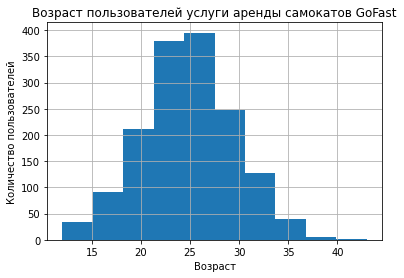

In [20]:
users['age'].hist()
plt.title('Возраст пользователей услуги аренды самокатов GoFast')
plt.xlabel('Возраст')
plt.ylabel('Количество пользователей')

In [21]:
users['age'].describe()

count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64

Услугой аренды самокатов GoFast пользуются люди от 12 до 43 лет, средний возраст пользователя - 25 лет, большинство пользователей в возрасте от 22 до 30 лет.

4. Посмотрим, какие *расстояния* преодолевают пользователи услуги аренды самокатов GoFast за 1 поездку.

Text(0, 0.5, 'Количество поездок')

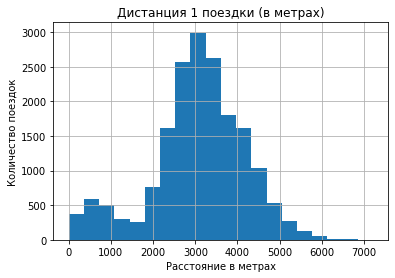

In [22]:
rides['distance'].hist(bins=20)
plt.title('Дистанция 1 поездки (в метрах)')
plt.xlabel('Расстояние в метрах')
plt.ylabel('Количество поездок')

In [23]:
rides['distance'].describe()  

count    18068.000000
mean      3070.659976
std       1116.831209
min          0.855683
25%       2543.226360
50%       3133.609994
75%       3776.222735
max       7211.007745
Name: distance, dtype: float64

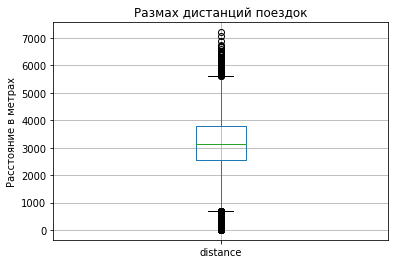

In [24]:
rides['distance'].plot.box(grid=True)
plt.title('Размах дистанций поездок')
plt.ylabel('Расстояние в метрах');

Средняя продолжительность поездки составляет около 3100 метров. Большая часть поездок пользователей имеет протяженность от 2000 до 4200 метров. 

5. Посмотрим, сколько *времени* пользователи тратят на 1 поездку на самокате GoFast.

Text(0, 0.5, 'Количество поездок')

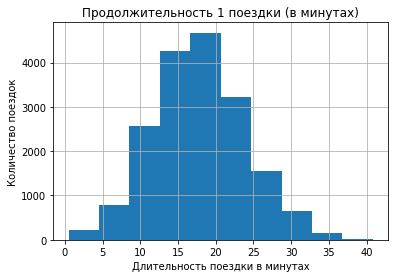

In [25]:
rides['duration'].hist()
plt.title('Продолжительность 1 поездки (в минутах)')
plt.xlabel('Длительность поездки в минутах')
plt.ylabel('Количество поездок')

In [26]:
rides['duration'].describe()  

count    18068.000000
mean        17.805011
std          6.091051
min          0.500000
25%         13.597563
50%         17.678395
75%         21.724800
max         40.823963
Name: duration, dtype: float64

В среднем пользователи тратят на 1 поездку около 18 минут. Большинство поездок имеют продолжительность от 10 до 25 минут. 

__Вывод__: представлены пользователи из 8 городов с наибольшей долей в г. Пятигорске (14%) и наименьшей - в г. Москве (11%), большинство из которых имеют подписку Ultra на услугу аренды самокатов GoFast (54% против 46% пользователей, не оформивших подписку). Большинство поездок совершаются на расстояние от 2000 до 4200 метров длительностью от 10 до 25 минут. Средняя протяженность 1 поездки - 3100 метров, средняя длительность 1 поездки - 18 минут.  

#### Шаг 4. Объединение данных

Для удобства дальнейшего анализа добавим в файл с информацией о поездках сведения о пользователях.

In [27]:
rides_plus = rides.merge(users, on='user_id', how='left')
rides_plus = rides_plus.merge(prices, on='subscription_type', how='left')
rides_plus.shape

(18068, 12)

In [28]:
rides_plus.sample(5)

,user_id,distance,duration,date,month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
13624,1219,4265.118727,23.236285,2021-02-15,2,Ксения,25,Пятигорск,free,8,50,0
3584,385,3048.714247,18.194857,2021-12-21,12,Мирон,24,Москва,ultra,6,0,199
12035,1104,4069.869371,20.174673,2021-09-30,9,Ольга,24,Краснодар,free,8,50,0
11192,1043,488.559314,5.954237,2021-06-04,6,Оксана,28,Москва,free,8,50,0
1046,112,4067.117884,18.761083,2021-07-09,7,Святослав,24,Краснодар,ultra,6,0,199


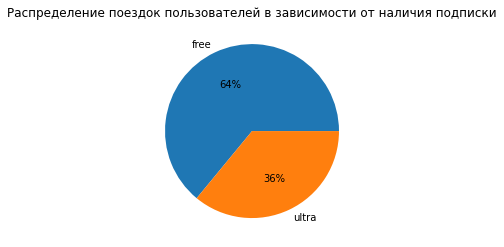

In [29]:
ax = (
    rides_plus['subscription_type']
    .value_counts()
    .plot(kind='pie', autopct='%1.0f%%', title='Распределение поездок пользователей в зависимости от наличия подписки')
)
ax.axes.yaxis.set_visible(False)
plt.show()

Пользователи без подписки совершают в 2 раза больше поездок, чем пользователи с подпиской.

Разделим датасет с расширенной информацией о поездках на два датафрейма:
- c данными о пользователях без подписки;
- с данными о пользователях с подпиской.

In [30]:
rides_plus['subscription_type'].unique()

array(['ultra', 'free'], dtype=object)

In [31]:
#данные о пользователях без подписки:
rides_plus_free = rides_plus[rides_plus['subscription_type'] == 'free']
print(rides_plus_free.shape)
rides_plus_free.head()

(11568, 12)


,user_id,distance,duration,date,month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
6500,700,2515.690719,14.944286,2021-01-02,1,Айдар,22,Омск,free,8,50,0
6501,700,846.932642,16.234663,2021-02-01,2,Айдар,22,Омск,free,8,50,0
6502,700,4004.434142,20.016628,2021-02-04,2,Айдар,22,Омск,free,8,50,0
6503,700,1205.911290,9.782872,2021-02-10,2,Айдар,22,Омск,free,8,50,0
6504,700,3047.379435,17.427673,2021-02-14,2,Айдар,22,Омск,free,8,50,0


In [32]:
#данные о пользователях с подпиской:
rides_plus_ultra = rides_plus[rides_plus['subscription_type'] == 'ultra']
print(rides_plus_ultra.shape)
rides_plus_ultra.head()

(6500, 12)


,user_id,distance,duration,date,month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,4409.919140,25.599769,2021-01-01,1,Кира,22,Тюмень,ultra,6,0,199
1,1,2617.592153,15.816871,2021-01-18,1,Кира,22,Тюмень,ultra,6,0,199
2,1,754.159807,6.232113,2021-04-20,4,Кира,22,Тюмень,ultra,6,0,199
3,1,2694.783254,18.511000,2021-08-11,8,Кира,22,Тюмень,ultra,6,0,199
4,1,4028.687306,26.265803,2021-08-28,8,Кира,22,Тюмень,ultra,6,0,199


Посмотрим, на какие *расстояния* совершают поездки пользователи услуги аренды самокатов GoFast c подпиской Ultra и без нее.

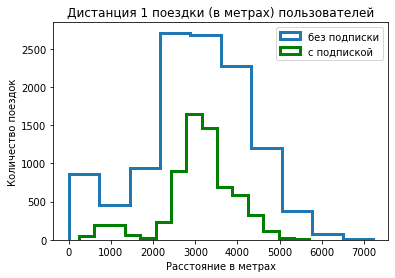

In [33]:
ax = rides_plus_free.plot(kind='hist', y='distance', histtype='step', linewidth=3, label='без подписки', grid=True, legend=True)
rides_plus_ultra.plot(kind='hist', y='distance', histtype='step', ax=ax, bins=15, color='green', linewidth=3, label='c подпиской')
plt.title('Дистанция 1 поездки (в метрах) пользователей')
plt.xlabel('Расстояние в метрах')
plt.ylabel('Количество поездок')
plt.show()

In [34]:
rides_plus_free['distance'].describe()

count    11568.000000
mean      3045.495282
std       1246.173806
min          0.855683
25%       2366.562689
50%       3114.648465
75%       3905.697894
max       7211.007745
Name: distance, dtype: float64

In [35]:
rides_plus_ultra['distance'].describe()

count    6500.000000
mean     3115.445388
std       836.895330
min       244.210438
25%      2785.444017
50%      3148.637229
75%      3560.574425
max      5699.769662
Name: distance, dtype: float64

Пользователи, не оформившие подписку, совершили 11 568 поездок (64% от общего количества), cредняя протяженность 1 поездки составила около 3100 метров, половина поездок совершена на расстояние от 2300 до 3900 метров. Пользователи с подпиской Uitra совершили 6 500 поездок (36% от общего количества), cредняя протяженность 1 поездки также составила около 3100 метров, при этом половина поездок совершена на расстояние от 2700 до 3600 метров.

Посмотрим, за какое *время* совершают поездки пользователи услуги аренды самокатов GoFast c подпиской Ultra и без нее.

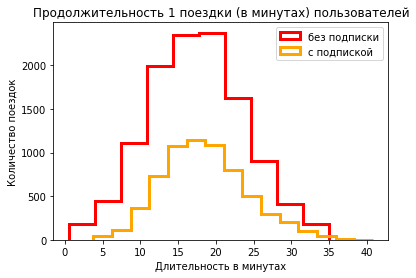

In [36]:
ax = rides_plus_free.plot(kind='hist', y='duration', histtype='step', color='red', linewidth=3, label='без подписки', grid=True, legend=True)
rides_plus_ultra.plot(kind='hist', y='duration', histtype='step', ax=ax, bins=15, color='orange', linewidth=3, label='c подпиской')
plt.title('Продолжительность 1 поездки (в минутах) пользователей')
plt.xlabel('Длительность в минутах')
plt.ylabel('Количество поездок')
plt.show()

In [37]:
rides_plus_free['duration'].describe()

count    11568.000000
mean        17.390909
std          6.326803
min          0.500000
25%         12.958437
50%         17.326890
75%         21.594071
max         34.948498
Name: duration, dtype: float64

In [38]:
rides_plus_ultra['duration'].describe()

count    6500.000000
mean       18.541985
std         5.572048
min         3.760353
25%        14.524654
50%        18.178153
75%        21.884129
max        40.823963
Name: duration, dtype: float64

Средняя продолжительность 1 поездки пользователей без подписки составила 17.4 минут, половина поездок совершена за время от 12.9 до 21.6 минут. Средняя продолжительность 1 поездки пользователей с подпиской Ultra составила 18.5 минут, половина поездок совершена за время от 14.5 до 21.9 минут.  

#### Шаг 5. Подсчёт выручки

Агрегируем данные о поездках: найдем суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц.

In [39]:
rides_plus['duration'] = np.ceil(rides_plus['duration'])
rides_plus_agr = rides_plus.groupby(['user_id', 'month', 'subscription_type']).agg({'distance': ['count', 'sum'], 'duration': ['sum']})
rides_plus_agr.columns = ['quantity', 'total_distance', 'total_duration']
rides_plus_agr = rides_plus_agr.reset_index()
rides_plus_agr = rides_plus_agr.merge(prices, on='subscription_type', how='left')
rides_plus_agr.sample(5)

,user_id,month,subscription_type,quantity,total_distance,total_duration,minute_price,start_ride_price,subscription_fee
6186,909,7,free,2,9389.187982,51.0,8,50,0
9301,1286,1,free,1,4030.894595,27.0,8,50,0
9935,1366,10,free,1,4317.393541,28.0,8,50,0
2795,429,6,ultra,1,2005.410200,13.0,6,0,199
7365,1051,3,free,1,2084.649191,15.0,8,50,0


Рассчитаем помесячную выручку, которую принёс каждый пользователь с учетом выбранного им тарифа. 

In [40]:
rides_plus_agr ['subscription_type'].unique()

array(['ultra', 'free'], dtype=object)

In [41]:
rides_plus_agr['monthly_income'] = rides_plus_agr['subscription_fee'] + \
     rides_plus_agr['start_ride_price'] * rides_plus_agr['quantity'] + \
     rides_plus_agr['minute_price'] * rides_plus_agr['total_duration']
rides_plus_agr.sample(5)

,user_id,month,subscription_type,quantity,total_distance,total_duration,minute_price,start_ride_price,subscription_fee,monthly_income
4400,677,3,ultra,1,5699.769662,19.0,6,0,199,313.0
7381,1053,4,free,1,4045.138890,27.0,8,50,0,266.0
6108,899,9,free,1,4612.215250,26.0,8,50,0,258.0
10555,1440,7,free,1,1959.218584,11.0,8,50,0,138.0
9080,1259,2,free,4,12702.644141,81.0,8,50,0,848.0


In [42]:
# проверим новый столбец на наличие в нем пропусков
rides_plus_agr['subscription_type'].isna().sum()

0

In [43]:
# посмотрим на размер нового датафрейма:
rides_plus_agr.shape

(11331, 10)

Созданный датафрейм `rides_plus_agr` содержит информацию о совершенных пользователями поездках в каждом месяце 2021 года (их количество, общая длительность в минутах и общая протяженность в метрах), а также информацию о размере помесячной выручки, полученной компанией от каждого пользователя. 

#### Шаг 6. Проверка гипотез

Перейдем к проверке гипотез.

6.1. **Гипотеза № 1:** *пользователи с подпиской тратят больше времени на поездки*.

Сформулируем нулевую гипотезу H0 как равенство длительности поездок у пользователей с подпиской и без нее. Альтернативную гипотезу H1 определим как длительность поездок пользователей с подпиской Ultra, больше чем у у пользователей, не оформивших подписку (правосторонняя гипотеза). Для проверки гипотезы № 1 проведем двухвыборочный t-test для независимых выборок.

In [44]:
# уровень статистической значимости зададим = 5%
alpha = 0.05
rides_dur_ultra = rides_plus_ultra['duration']
print (f'Средняя длительность совершенных поездок пользователями с подпиской Ultra (в минутах): {np.mean(rides_dur_ultra)}')
rides_dur_free = pd.Series(rides_plus_free['duration'])
print (f'Средняя длительность совершенных поездок пользователями без подписки (в минутах): {np.mean(rides_dur_free)}')
results = st.ttest_ind(rides_dur_ultra, rides_dur_free, alternative='greater')
print('p-value:', results.pvalue)
if results.pvalue < alpha:
    print ('Отвергаем нулевую гипотезу. Гипотеза № 1 не опровергнута - пользователи с подпиской тратят больше времени на поездки.')
else:
    print ('Не получилось отвергнуть нулевую гипотезу. Пользователи с подпиской не тратят больше времени на поездки.')

Средняя длительность совершенных поездок пользователями с подпиской Ultra (в минутах): 18.54198516280583
Средняя длительность совершенных поездок пользователями без подписки (в минутах): 17.39090929866399
p-value: 1.2804098316645618e-34
Отвергаем нулевую гипотезу. Гипотеза № 1 не опровергнута - пользователи с подпиской тратят больше времени на поездки.


In [45]:
# код ревьюера
type(rides_plus_free['duration'])

pandas.core.series.Series

**Вывод № 1:** гипотеза № 1 не отвергается - более вероятно, что пользователи с подпиской тратят больше времени на поездки, чем пользователи, не оформившие подписку, то есть пользователи с подпиской могут быть «выгоднее» для компании.

6.2. **Гипотеза № 2:** *среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров*.

Сформулируем нулевую гипотезу H0 как среднее расстрояние поездок у пользователей с подпиской = 3130 метров. Альтернативную гипотезу H1 определим как как среднее расстрояние поездок у пользователей с подпиской больше 3130 метров (правосторонняя гипотеза). Для проверки гипотезы № 2 проведем одновыборочный t-test.

In [46]:
# уровень статистической значимости зададим = 5%
alpha = 0.05
rides_dist_ultra = pd.Series(rides_plus_ultra['distance'])
print (f'Средняя протяженность совершенных поездок пользователями с подпиской Ultra (в метрах): {np.mean(rides_dist_ultra)}')
limit = 3131

results = st.ttest_1samp(rides_dist_ultra, limit, alternative='greater')
print('p-value:', results.pvalue)
if results.pvalue < alpha:
    print ('Отвергаем нулевую гипотезу. Пользователи с подпиской в среднем проезжают за одну поездку больше 3130 метров.')
else:
    print ('Не получилось отвергнуть нулевую гипотезу. Среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров.')

Средняя протяженность совершенных поездок пользователями с подпиской Ultra (в метрах): 3115.4453880370247
p-value: 0.932968630297281
Не получилось отвергнуть нулевую гипотезу. Среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров.


**Вывод № 2:** гипотеза № 2 не отвергается - среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, с высокой долей вероятности не превышает 3130 метров, что означает, что наличие подписки не влияет на длительность поездок и не способствуют износу парка самокатов и, как следствие, увеличению расходов компании.

6.3. **Гипотеза № 3:** *помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки*.

Сформулируем нулевую гипотезу H0 как равенство средних размеров ежемесячной выручки, вырученной от сдачи в аренду самокатов пользователям с подпиской Ultra и пользователям, не оформившим подписку. Альтернативную гипотезу H1 определим как "средний размер ежемесячной выручки, вырученной от сдачи в аренду самокатов пользователям с подпиской Ultra, больше чем средний размер ежемесячной выручки, вырученной от сдачи в аренду самокатов пользователям, не оформившим подписку (правосторонняя гипотеза). Для проверки гипотезы № 3 проведем двухвыборочный t-test для независимых выборок.

Для проверки данной гипотезы разделим датасет, содержащий информацию о выручке, помесячно полученной компанией от сдачи в аренду самокатов пользователям, на два датафрейма:
- c данными о пользователях без подписки;
- с данными о пользователях с подпиской.

In [47]:
rides_income_ultra = rides_plus_agr[rides_plus_agr['subscription_type'] == 'ultra']
print('Размер сводных данных о поездках пользователей с подпиской Ultra:', rides_income_ultra.shape)
rides_income_free = rides_plus_agr[rides_plus_agr['subscription_type'] == 'free']
print('Размер сводных данных о поездках пользователей без подписки Ultra:', rides_income_free.shape)

Размер сводных данных о поездках пользователей с подпиской Ultra: (4533, 10)
Размер сводных данных о поездках пользователей без подписки Ultra: (6798, 10)


In [48]:
# уровень статистической значимости зададим = 5%
alpha = 0.05
income_ultra = pd.Series(rides_income_ultra['monthly_income'])
print (f'Среднемесячная выручка от совершенных поездок пользователями с подпиской Ultra (в рублях): {np.mean(income_ultra)}')
income_free = pd.Series(rides_income_free['monthly_income'])
print (f'Среднемесячная выручка от совершенных поездок пользователями без подписки (в рублях): {np.mean(income_free)}')

results = st.ttest_ind(income_ultra, income_free, alternative='greater')
print('p-value:', results.pvalue)
if results.pvalue < alpha:
    print ('Отвергаем нулевую гипотезу. Гипотеза № 3 не опровергнута - выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.')
else:
    print ('Не получилось отвергнуть нулевую гипотезу. Выручка от пользователей с подпиской по месяцам не выше, чем выручка от пользователей без подписки.')

Среднемесячная выручка от совершенных поездок пользователями с подпиской Ultra (в рублях): 362.7921906022502
Среднемесячная выручка от совершенных поездок пользователями без подписки (в рублях): 328.6413651073845
p-value: 1.8850394384715216e-31
Отвергаем нулевую гипотезу. Гипотеза № 3 не опровергнута - выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.


**Вывод № 3:** гипотеза № 3 не отвергается - более вероятно, что выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей, не оформивших подписку, то есть акции, направленные на увеличение пользователей, оформивших подписку Ultra, могут привести к увеличению прибыли компании в будущем.

6.4. В случае, если техническая команда сервиса обновит сервера, с которыми взаимодействует мобильное приложение, с целью значимого снижения количества обращений в техподдержку, и предоставит информацию, содержащую для каждого пользователя данные о количестве обращений до обновления и после него, то возможно провести двухвыборочный t-тест для зависимых выборок для проверки гипотезы, что количество обращений пользователей после обновления серверов снизилось. 

Нулевая гипотеза H0 в данном случае будет определена как равенство среднего количества обращений пользователей до обновления серверов и после обновления. Альтернативную гипотезу H1 определим как "среднее количество обращений пользователей после обновления серверов меньше, чем до обновления" (левосторонняя гипотеза).

#### Шаг 7. Распределения

**7.1.** Задача отдела маркетинга GoFast: нужно провести акцию с раздачей промокодов на один бесплатный месяц подписки, в рамках которой как минимум 100 существующих клиентов должны продлить эту подписку, то есть по завершении периода действия подписки пользователь может либо отказаться от неё, либо продлить, совершив соответствующий платёж. 

Эта акция уже проводилась ранее и по итогу выяснилось, что после бесплатного пробного периода подписку продлевают 10 % пользователей. 

Выясним, какое минимальное количество промокодов нужно разослать, чтобы вероятность не выполнить план была примерно 5 %. 
Для этого используем биномиальное распределение, которое описывает указанную ситуацию.

Вероятность, что из 1160 пользователей, получивших промокод на один бесплатный месяц подписки, 
100 продлят подписку составляет 0.95


/opt/conda/lib/python3.9/site-packages/scipy/stats/_discrete_distns.py:78: RuntimeWarning: divide by zero encountered in _binom_pdf
  return _boost._binom_pdf(x, n, p)


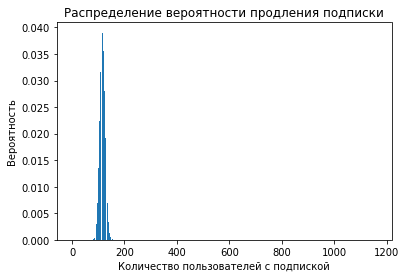

In [49]:
n = 1160 # количество клиентов, которым нужно раздать промокоды
p = 0.1 # вероятность успеха

print (f'''Вероятность, что из {n} пользователей, получивших промокод на один бесплатный месяц подписки, 
100 продлят подписку составляет {round(1-binom.cdf(99, n, p), 2)}''')

distr = []

for k in range(0, n + 1):
    current_value = binom.pmf(k, n, p)
    distr.append(current_value)
    
plt.bar(range(0, n + 1), distr)
plt.title('Распределение вероятности продления подписки')
plt.xlabel('Количество пользователей с подпиской')
plt.ylabel('Вероятность')
plt.show();

***Вывод:*** согласно построенному биноминальному распределению необходимо разослать минимум 1160 промокодов, чтобы вероятность не выполнить план была примерно 5 %.

**7.2.** Отдел маркетинга рассылает клиентам push-уведомления в мобильном приложении. Известно, что уведомления открывают около 
40 % получивших клиентов. Отдел планирует разослать 1 млн уведомлений. 

Найдем вероятность того, что уведомление откроют не более 399,5 тыс. пользователей.

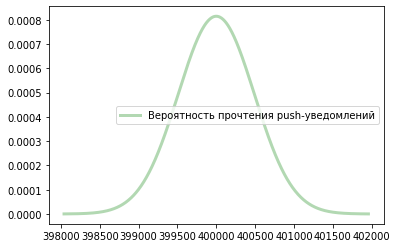

Вывод: вероятность того, что уведомление откроют не более 399,5 тыс. пользователей составляет: 0.15


In [50]:
from math import sqrt
# задаём параметры биномиального распределения
n = 1000000
p = 0.4
# зададим мат.ожидание и ст.отклонение нормального распределения равными 
# мат.ожиданию и ст.отклонению биномиального распределения
mu = n * p
sigma = sqrt(n * p * (1 - p))
# задаём нормальное распределение
distr = st.norm(mu, sigma) 
# считаем вероятность того, что уведомление откроют не более 399,5 тыс. пользователей:
result = distr.cdf(399500)

# построим график нормального распределения
def linspace(start, stop, num):
    step = (stop - start) / (num - 1)
    result = []
    for i in range(num):
        result.append(start + step * i)
    return result
left = int(n * p - 4 * sqrt(n * p * (1 - p)))
right = int(n * p + 4 * sqrt(n * p * (1 - p)))
x = linspace(left, right, 1000)
plt.plot(x, norm.pdf(x, mu, sigma), 'g-', lw=3, alpha=0.3, label='Вероятность прочтения push-уведомлений')
plt.legend(loc='best')
plt.show()
print(f'Вывод: вероятность того, что уведомление откроют не более 399,5 тыс. пользователей составляет: {round(result,2)}')


#### Вывод

**Исходные данные:** в ходе исследования был проведен анализ данных о пользователях и совершенных ими поездках на самокатах сервиса аренды самокатов GoFast.

**Цель исследования** - проверить гипотезы, которые могут помочь бизнесу вырасти в результате проведения акций, способствующих увеличению количества пользователей с подпиской Ultra.
    
Исходные данные включают в себя информацию о 1565 пользователях и 18068 совершенных ими поездках, а также информацию о тарифах на аренду самокатов (с подпиской Ultra и без подписки). В ходе преобработки исходных данных обнаружен 31 дубликат в строках, содержащих информацию о пользователях, которые были удалены, в результате чего количество уникальных пользователей составило 1534.

Для анализа дополнительно добавлены новые данные, исходя из имеющихся данных в других столбцах, а также информации от тарифах на аренду самокатов:
* месяц совешения поездки;
* ежемесячная выручка компании от услуги аренды самокатов в разрезе пользователей.
    
**Исследование:** 

1. В ходе исследования выявлено, что услугой аренды самокатов GoFast пользуются в 8 городах примерно одинаково, но наибольшее распространение услуга имеет в г. Пятигорске (219 пользователей), меньше всего представлены пользователи из г. Москвы (168 пользователей).

2. Пользователей без подписки на 8% больше, чем пользователей, оформивших подписку Ultra (54% против 46%).

3. Услугой аренды самокатов GoFast пользуются люди от 12 до 43 лет, средний возраст пользователя - 25 лет, большинство пользователей в возрасте от 22 до 30 лет.

4. Средняя продолжительность поездки составляет около 3100 метров. Большая часть поездок пользователей имеет протяженность от 2000 до 4200 метров. 

5. В среднем пользователи тратят на 1 поездку около 18 минут. Большинство поездок имеют продолжительность от 10 до 25 минут. 

6. Пользователи без подписки совершают в 2 раза больше поездок, чем пользователи с подпиской (64% против 36%).

7. Средняя протяженность 1 поездки пользователей с подпиской Uitra и пользователей без подписки примерно равна и составляет около 3100 метров. При этам половина поездок пользователями без подписки совершена на расстояние от 2300 до 3900 метров, а пользователями с подпиской Uitra - на расстояние от 2700 до 3600 метров.

8. Средняя продолжительность 1 поездки пользователей без подписки составила 17.4 минут, половина поездок совершена за время от 12.9 до 21.6 минут. Средняя продолжительность 1 поездки пользователей с подпиской Ultra составила 18.5 минут, половина поездок совершена за время от 14.5 до 21.9 минут.  

9. Среднемесячная выручка от совершенных поездок пользователями с подпиской Ultra составляеь 362.79 рублей.
Среднемесячная выручка от совершенных поездок пользователями без подписки - 328.64 рублей.

    
**Проверка гипотез:**

В ходе исследования были проверены 3 гипотезы.

**Гипотеза № 1**, что пользователи с подпиской тратят больше времени на поездки, не отвергнута - более вероятно, что пользователи с подпиской тратят больше времени на поездки, чем пользователи, не оформившие подписку, то есть пользователи с подпиской могут быть «выгоднее» для компании. Этот вывод можно учитывать при подготовке промо-акций для увеличения пользователей улуги аренды самокатов с подпиской Ultra.

**Гипотеза № 2**, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает оптимального расстояния с точки зрения износа самоката (3130 метров), не отвергнута - с высокой долей вероятности среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров, что означает, что наличие подписки не влияет на длительность поездок и не способствуют износу парка самокатов и, как следствие, увеличению расходов компании.

**Гипотеза № 3**, что помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки, не отвергнута - более вероятно, что выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей, не оформивших подписку, то есть промо-акции, направленные на увеличение пользователей, оформивших подписку Ultra, могут привести к увеличению прибыли компании в будущем.

С учетом ранее проведенных промо-акций для получения 100 новых подписчиков Ultra при существующей вероятности продления подписки в 10 % требется раздать 1160 промокодов на 1 бесплатный месяц подписки.

С учетом ранее проведенных рассылок с вероятностью в 85% больше половины из 1000000 разосланных push-уведомления в мобильном приложении будут прочтены пользователями.


***Рекомендации:***
1. Рассмотреть целесообразность введения системы мониторинга протяженности непрерывных поездок на самокатах для своевременного выявления неоходимости проведения их техобслуживания с целью снижения незапланированных расходов.
2. В силу того, что все три гипотезы не были отвергнуты, есть все основания полагать, что пользователи с подпиской являются более "выгодными" для компании, в связи с чем имеет смысл разработать план проведения промо-акций с целью привлечения потребителей оформить/продлить подписку Ultra как более прибыльную для компании с учетом имеющегося опыта ранее проведенных промо-акций.
3. Использовать рассылку push-уведомлений в мобильном приложении как достаточно эффективный способ связи с потребителями.